In [1]:
import pandas as pd
dados = pd.read_csv("coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv")
dados.dropna(subset=dados.columns,inplace=True)
dados.index = range(dados.shape[0])
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1990691 entries, 0 to 1990690
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 121.5 MB


# Médias Móveis

Média Móvel é uma media do preço dos ultimos N fechamentos de um ativo.

Sendo que o N é chamado de periodo, e esta sendo utilizando um periodo de 20. Dependendo do dataset, 20 periodos podem ser 20 minutos, 20 horas, 20 dias ou 20 anos.

No dataset utilizado 20 periodos representam 20 minutos.

In [2]:
media=dados['Close'].rolling(window=20).mean()
media

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
1990686    4010.9300
1990687    4010.4410
1990688    4010.0095
1990689    4009.3820
1990690    4008.9380
Name: Close, Length: 1990691, dtype: float64

# Médias Móveis Exponenciais

Média Móvel Exponencial é uma media ponderada do preço dos ultimos N fechamentos de um ativo, dando mais peso para os fechamentos mais próximos.

Sendo que o N é chamado de periodo, e esta sendo utilizando um periodo de 20. Dependendo do dataset, 20 periodos podem ser 20 minutos, 20 horas, 20 dias ou 20 anos.

No dataset utilizado 20 periodos representam 20 minutos.

In [3]:
media = dados['Close'].ewm(span=20, adjust=False).mean()
media

0           300.000000
1           300.000000
2           306.666667
3           312.698413
4           318.822373
              ...     
1990686    4009.408206
1990687    4009.084568
1990688    4008.791752
1990689    4008.478252
1990690    4008.241275
Name: Close, Length: 1990691, dtype: float64

# Índices de Força Relativa
O indice de força relativa (RSI em inglês) foi desenvolvido por J. Welles Wilder. É um indice com escala de variação fixa, ou seja, varia entre 0 e 100.

É usado para identificar a subvalorização ou sobrevalorização de um ativo. Exemplo: Quanto maior o indice (>70) mais sobrevalorizada o ativo esta, e quanto menor o indice (<30) mais subvalorizada o ativo esta.

**IFR = 100 – (100 ÷ (1+ (U/D))**


* IFR = Índice de Força Relativa
* U = Média das cotações dos últimos n dias em que a cotação da ação subiu. Trata-se da soma das cotações dos últimos n dias em que a cotação da ação subiu, dividido por n.
* D = Média das cotações dos últimos n dias em que a cotação da ação caiu. Trata-se da soma das cotações dos últimos n dias em que a cotação da ação caiu, dividido por n.
* n = O numero de dias mais utilizado pelo mercado é 14, e recomendado por Wilder quando da publicação de seu livro. Por isso, esse é o default da plataforma gráfica de análise técnica do Bússola do Investidor. Mas também é comum usar um IFR de 9 ou 25 dias, e você pode customizar o indicador para quantos períodos desejar.

In [4]:
import numpy as np

def calcula_indices_de_força_relativa(precos, n=14):
        """Retorna uma lista com os índices de força relativa dado uma Serie de preços"""
        # Qual que é a ideia
        # Calcular os deltas, que sao a diferença entre o preço[0] e o preço[1]
        # Calcular o rsi pros n primeiros deltas;
        # Esses n-rsi primeiros serao iguais obviamente;
        # Depois vou percorrer os deltas faltantes pra calcular os rsi faltantes
        # Dentro do for vou corrigindo os valores da media da taxa de cotação quando ela sobe e quando ela desce
        # Depois calculo o RSI usando a media da taxa de cotação corrigida

        
        # fazendo o calculo dos n primeiros pra inicializar a conta

        deltas = np.diff(precos)  # pegando a diferença preco[0]-preco[1] e guardando em deltas[0]
        primeiros = deltas[:n]  # pegando as diferença 14 primeiras diferenças
                
        ganho = primeiros[primeiros >= 0].sum() / n  # media das diferenças positivas dentre as 14 iniciais
        perda = -primeiros[primeiros < 0].sum() / n  # media das diferenças negativas dentre as 14 iniciais

        forca_relativa = ganho / perda  # calculando a força relativa

        rsi = np.zeros_like(precos)  # criando uma copia de precos só com zeros

        rsi[:n] = 100. - 100. / (1. + forca_relativa)  # calculando rsi para os 14 primeiros precos, serao iguais

        # print(deltas,primeiros,ganho,perda,rsi[:n+1], sep='\n')
        # print(deltas[:n+1])

        # for pra calcular o resto dos rsi
        for i in range(n, len(precos)):
            delta = deltas[i - 1]
            # tem que ser deltas[i-1] porque é a diferença do preço anterior com o preço atual
            # se fosse deltas[i] seria a diferença do preço atual com o proximo preço

            if (delta >= 0):
                ganho_variacao = delta
                perda_variacao = 0.
            else:
                ganho_variacao = 0.
                perda_variacao = -delta

            # corrigindo
            ganho = (ganho * (n - 1) + ganho_variacao) / n
            perda = (perda * (n - 1) + perda_variacao) / n

            forca_relativa = ganho / perda

            rsi[i] = 100. - 100. / (1. + forca_relativa)

        return rsi

In [5]:
indice_rsi = calcula_indices_de_força_relativa(dados['Close'])
indice_rsi = pd.DataFrame(data=indice_rsi)
indice_rsi

,0
0,99.872123
1,99.872123
2,99.872123
3,99.872123
4,99.872123
...,...
1990686,36.386558
1990687,36.386558
1990688,36.386558
1990689,34.990379


# Criando coluna DateTime

In [6]:
from datetime import datetime
import time

def fun_date (x):
    dt = datetime.utcfromtimestamp(x)    
    return dt
dados['Datetime'] = dados['Timestamp'].apply(fun_date)


dados.index= range(dados.shape[0])

dados.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Datetime
0,1417411980,300.00,300.0,300.00,300.0,0.010000,3.00000,300.000000,2014-12-01 05:33:00
1,1417412400,300.00,300.0,300.00,300.0,0.010000,3.00000,300.000000,2014-12-01 05:40:00
2,1417415040,370.00,370.0,370.00,370.0,0.010000,3.70000,370.000000,2014-12-01 06:24:00
3,1417416600,370.00,370.0,370.00,370.0,0.026556,9.82555,370.000000,2014-12-01 06:50:00
4,1417498140,377.00,377.0,377.00,377.0,0.010000,3.77000,377.000000,2014-12-02 05:29:00
5,1417517940,377.75,378.0,377.75,378.0,4.000000,1511.93750,377.984375,2014-12-02 10:59:00
6,1417518240,378.00,378.0,378.00,378.0,4.900000,1852.20000,378.000000,2014-12-02 11:04:00
7,1417518300,378.00,378.0,378.00,378.0,5.200000,1965.60000,378.000000,2014-12-02 11:05:00
8,1417545780,378.00,378.0,378.00,378.0,0.100000,37.80000,378.000000,2014-12-02 18:43:00
9,1417546680,378.00,378.0,378.00,378.0,0.793600,299.98080,378.000000,2014-12-02 18:58:00


# Teste gráficos

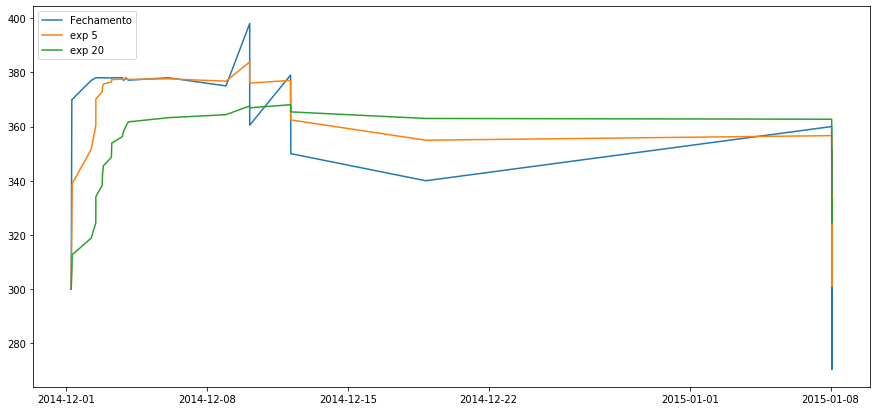

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,7)

selecao = (dados["Timestamp"] >= 1417411980 ) & (dados["Timestamp"] <= 1420681680)
df = dados[selecao]

exp1=df['Close'].ewm(span=5, adjust=False).mean()
exp2=df['Close'].ewm(span=20, adjust=False).mean()

plt.plot(df['Datetime'], df['Close'], label='Fechamento')
plt.plot(df['Datetime'], exp1, label='exp 5')
plt.plot(df['Datetime'], exp2, label='exp 20')
plt.legend(loc='upper left')
plt.show()

*  O periodo de minutos é muito ruim de trabalhar, vamo transformar isso em dias.

# Criando novo DataSet com periodo em DIAS

* Vou pegar a coluna Datetime e a coluna Close e passar para o novo dataset a media dos fechamentos dos candles no dia

In [8]:
ultima_data = dados['Datetime'][-1:].values # 2019-01-07 22:06:00
ultima_data = ultima_data[0]
ultima_data = pd.to_datetime(ultima_data)
ultima_data

Timestamp('2019-01-07 22:06:00')

In [9]:
data_inicial =  pd.to_datetime('12-01-2014 00:00')
dic_mes = {}
while(data_inicial < ultima_data):    
    selecao = (dados['Datetime'] >= data_inicial) & (dados['Datetime'] < data_inicial + pd.DateOffset(1))
    aux = dados[selecao]

    dic_mes[data_inicial.date()] = aux['Close'].mean()    
    
    data_inicial = data_inicial + pd.DateOffset(1)

In [10]:
dados_mes = pd.Series(dic_mes).to_frame('Close')
dados_mes.dropna(subset=dados_mes.columns,inplace=True)
dados_mes
#Media dos fechamentos naquele dia

,Close
2014-12-01,335.000000
2014-12-02,377.857143
2014-12-03,377.818333
2014-12-04,377.100000
2014-12-06,378.000000
...,...
2019-01-03,3829.922118
2019-01-04,3785.405590
2019-01-05,3834.609424
2019-01-06,3874.451625


# Gráficos com DataSet em DIAS

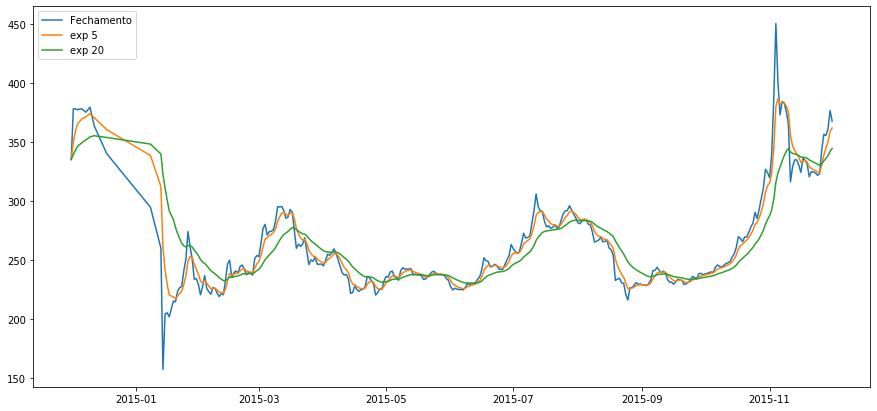

In [11]:
data_1 = pd.to_datetime('12-01-2014')
data_2 = pd.to_datetime('12-01-2015')
selecao = (dados_mes.index >= data_1  ) & (dados_mes.index <= data_2)
df_mes = dados_mes[selecao]

exp1=df_mes['Close'].ewm(span=5, adjust=False).mean()
exp2=df_mes['Close'].ewm(span=20, adjust=False).mean()

plt.plot(df_mes.index, df_mes['Close'], label='Fechamento')
plt.plot(df_mes.index, exp1, label='exp 5')
plt.plot(df_mes.index, exp2, label='exp 20')
plt.legend(loc='upper left')
plt.show()